In [1]:
import sys, os 
sys.path.insert(0, os.path.dirname(os.getcwd()))

# @title Imports
import dataclasses
import datetime
import functools
import math
import re
from typing import Optional
from glob import glob

import cartopy.crs as ccrs
#from google.cloud import storage
from wofscast import autoregressive
from wofscast import casting
from wofscast import checkpoint
from wofscast import data_utils
from wofscast import my_graphcast as graphcast
from wofscast import normalization
from wofscast import rollout
from wofscast import xarray_jax
from wofscast import xarray_tree
from IPython.display import HTML
import ipywidgets as widgets
import haiku as hk
import jax
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import xarray #as xr

# For training the weights!
import optax

from wofscast.utils import count_total_parameters, save_model_params, load_model_params 


In [2]:
# Notes on GraphCast Changes to run with WoFS data.

# 1. Introduced time dimension with timedeltas dataset
# 2. Introduce level dimension to the dataset 
# 3. Added try/excepts for xarray_jax to avoid PyTree errors about registry 
# 4. Cuda-enabled jaxlib error; had to install jax with this command for Cuda 11.8 
# pip install --upgrade "jax[cuda11_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# 5. Need to add the forcing variables (radiation) to the dataset
# 6. Xarray 2024.1.1 raised TracerArrayConversionError, downgraded to 2023.7.0, the version 
#    used in colab in the demo notebook.

In [3]:
mesh_size = 5
latent_size = 128 
gnn_msg_steps = 8
hidden_layers = 1

In [4]:
input_variables = ['U', 'V', 'W', 'T']#, 'P', 'REFL_10CM', 'UP_HELI_MAX']
target_variables = ['U', 'V', 'W', 'T']#, 'P', 'REFL_10CM', 'UP_HELI_MAX']
forcing_variables = ["XLAND"]

vars_2D = [] #['UP_HELI_MAX']

# Weights used in the loss equation.
VARIABLE_WEIGHTS = {v : 1.0 for v in target_variables}

# Not pressure levels, but just vertical array indices at the moment. 
pressure_levels = np.arange(0,40) #list(np.arange(0,30,4))
radius_query_fraction_edge_length=5

# Loads data from the past 10 minutes and 
# creates a target lead time 5-30, in 5 min intervals
input_duration = '20min'
#train_lead_times = '15min' 
eval_lead_times = slice('5min', '115min')#'235min')

In [5]:
model_config = graphcast.ModelConfig(
      resolution=0,
      mesh_size=mesh_size,
      latent_size=latent_size,
      gnn_msg_steps=gnn_msg_steps,
      hidden_layers=hidden_layers,
      radius_query_fraction_edge_length=radius_query_fraction_edge_length)

task_config = graphcast.TaskConfig(
      input_variables=input_variables,
      target_variables=target_variables,
      forcing_variables=forcing_variables,
      pressure_levels=pressure_levels,
      input_duration=input_duration,
  )

In [14]:
# Load the data 
data_paths = glob(os.path.join('/work/mflora/wofs-cast-data/datasets/dataset*.nc'))
data_paths.sort()

path = data_paths[10]
dataset = xarray.load_dataset(path).compute()

# @title Extract training and eval data
example_batch = dataset.expand_dims(dim='batch', axis=0)

# just load some data from the last dataset for evaluation. 
eval_inputs, eval_targets, eval_forcings = data_utils.extract_inputs_targets_forcings(
        example_batch, target_lead_times=eval_lead_times,
        **dataclasses.asdict(task_config))


print("All Examples:  ", example_batch.dims.mapping)
print("*"*80)
print("Eval Inputs:   ", eval_inputs.dims.mapping)
print("Eval Targets:  ", eval_targets.dims.mapping)
print("Eval Forcings: ", eval_forcings.dims.mapping)

All Examples:   {'batch': 1, 'time': 19, 'lat': 150, 'lon': 150, 'level': 50, 'datetime': 19}
********************************************************************************
Eval Inputs:    {'batch': 1, 'time': 2, 'level': 40, 'lat': 150, 'lon': 150}
Eval Targets:   {'batch': 1, 'time': 12, 'level': 40, 'lat': 150, 'lon': 150}
Eval Forcings:  {'batch': 1, 'time': 12, 'lat': 150, 'lon': 150}


In [15]:
# Load the normalization datasets
base_path = '/work/mflora/wofs-cast-data/normalization_stats'
mean_by_level = xarray.load_dataset(os.path.join(base_path, 'mean_by_level.nc'))
stddev_by_level = xarray.load_dataset(os.path.join(base_path, 'stddev_by_level.nc'))
diffs_stddev_by_level = xarray.load_dataset(os.path.join(base_path, 'diffs_stddev_by_level.nc'))

In [16]:
# @title Build jitted functions, and possibly initialize random weights

# Load saved model params and test! 
base_path = '/work/mflora/wofs-cast-data/model/'
params_path = os.path.join(base_path, 'params.npz')

model_params = load_model_params(params_path)
state = {}

def construct_wrapped_graphcast(
    model_config: graphcast.ModelConfig,
    task_config: graphcast.TaskConfig):
    """Constructs and wraps the GraphCast Predictor."""

    # Deeper one-step predictor.
    predictor = graphcast.GraphCast(model_config, task_config, VARIABLE_WEIGHTS, vars_2D)

    # Modify inputs/outputs to `graphcast.GraphCast` to handle conversion to
    # from/to float32 to/from BFloat16.
    predictor = casting.Bfloat16Cast(predictor)

    # Modify inputs/outputs to `casting.Bfloat16Cast` so the casting to/from
    # BFloat16 happens after applying normalization to the inputs/targets.
    predictor = normalization.InputsAndResiduals(
      predictor,
      diffs_stddev_by_level=diffs_stddev_by_level,
      mean_by_level=mean_by_level,
      stddev_by_level=stddev_by_level)

    # Wraps everything so the one-step model can produce trajectories.
    predictor = autoregressive.Predictor(predictor, gradient_checkpointing=True)
    
    return predictor


@hk.transform_with_state
def run_forward(model_config, task_config, inputs, targets_template, forcings):
  predictor = construct_wrapped_graphcast(model_config, task_config)
  return predictor(inputs, targets_template=targets_template, forcings=forcings)


@hk.transform_with_state
def loss_fn(model_config, task_config, inputs, targets, forcings):
  predictor = construct_wrapped_graphcast(model_config, task_config)
  loss, diagnostics = predictor.loss(inputs, targets, forcings)
  return xarray_tree.map_structure(
      lambda x: xarray_jax.unwrap_data(x.mean(), require_jax=True),
      (loss, diagnostics))

def grads_fn(params, state, model_config, task_config, inputs, targets, forcings):
  def _aux(params, state, i, t, f):
    (loss, diagnostics), next_state = loss_fn.apply(
        params, state, jax.random.PRNGKey(0), model_config, task_config,
        i, t, f)
    return loss, (diagnostics, next_state)
  (loss, (diagnostics, next_state)), grads = jax.value_and_grad(
      _aux, has_aux=True)(params, state, inputs, targets, forcings)
  return loss, diagnostics, next_state, grads

# Jax doesn't seem to like passing configs as args through the jit. Passing it
# in via partial (instead of capture by closure) forces jax to invalidate the
# jit cache if you change configs.
def with_configs(fn):
  return functools.partial(
      fn, model_config=model_config, task_config=task_config)

# Always pass params and state, so the usage below are simpler
def with_params(fn):
  return functools.partial(fn, params=model_params, state=state)

# Our models aren't stateful, so the state is always empty, so just return the
# predictions. This is requiredy by our rollout code, and generally simpler.
def drop_state(fn):
  return lambda **kw: fn(**kw)[0]

init_jitted = jax.jit(with_configs(run_forward.init))

In [17]:
count_total_parameters(model_params)

1428768

### Run the model forward based on the new model params

In [18]:
# Always pass params and state, so the usage below are simpler
def with_model_params(fn):
  return functools.partial(fn, params=model_params, state=state)

run_forward_jitted = drop_state(with_model_params(jax.jit(with_configs(
    run_forward.apply))))

# @title Autoregressive rollout (keep the loop in JAX)
print("Inputs:  ", eval_inputs.dims.mapping)
print("Targets: ", eval_targets.dims.mapping)
print("Forcings:", eval_forcings.dims.mapping)

predictions = rollout.chunked_prediction(
    run_forward_jitted,
    rng=jax.random.PRNGKey(0),
    inputs=eval_inputs,
    targets_template=eval_targets * np.nan,
    forcings=eval_forcings)

predictions

Inputs:   {'batch': 1, 'time': 2, 'level': 40, 'lat': 150, 'lon': 150}
Targets:  {'batch': 1, 'time': 12, 'level': 40, 'lat': 150, 'lon': 150}
Forcings: {'batch': 1, 'time': 12, 'lat': 150, 'lon': 150}


<xarray.Dataset>
Dimensions:  (time: 12, batch: 1, level: 40, lat: 150, lon: 150)
Coordinates:
  * time     (time) timedelta64[ns] 00:05:00 00:15:00 ... 01:45:00 01:55:00
  * lat      (lat) float32 30.06 30.09 30.12 30.14 ... 34.03 34.05 34.08 34.11
  * lon      (lon) float32 89.24 89.27 89.3 89.33 ... 93.67 93.7 93.73 93.76
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39
Dimensions without coordinates: batch
Data variables:
    T        (time, batch, level, lat, lon) float32 299.9 299.9 ... 425.0 426.4
    U        (time, batch, level, lat, lon) float32 2.365 2.569 ... 24.68 24.16
    V        (time, batch, level, lat, lon) float32 4.142 4.405 ... 0.6268 1.182
    W        (time, batch, level, lat, lon) float32 -0.002282 ... -0.1506

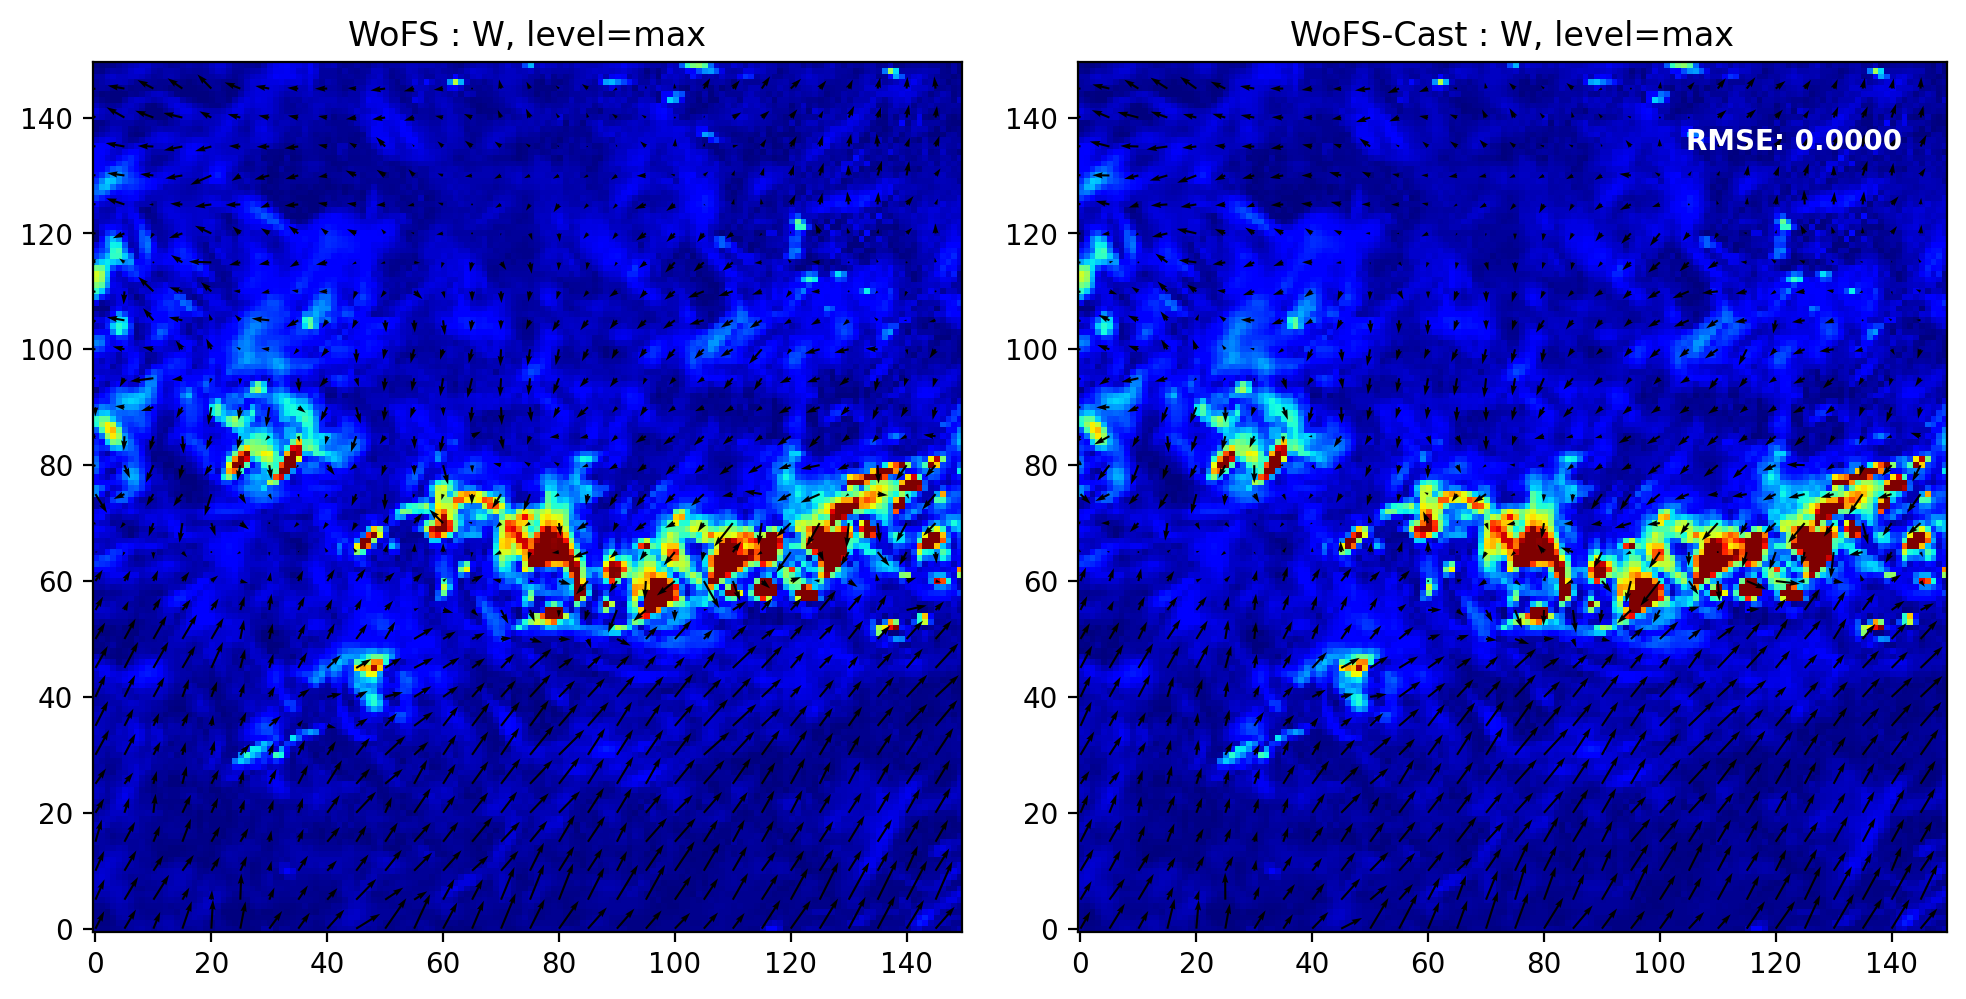

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

preds = predictions.squeeze(dim='batch', drop=True)
targets = eval_targets.squeeze(dim='batch', drop=True)

init_ds = eval_inputs.squeeze(dim='batch', drop=True)
init_ds = init_ds.isel(time=[0])

var = 'W'
level = 'max'

# Function to get target and prediction pair with the selected level
def get_target_and_pred_pair(preds, targets, t, level=0):
    if level == 'max':
        zs = [targets[var][t].max(dim='level').values, preds[var][t].max(dim='level').values]
    elif level == 'min': 
        zs = [targets[var][t].min(dim='level').values, preds[var][t].min(dim='level').values]
    elif level == 'none':
        zs = [targets[var][t].values, preds[var][t].values]
    else:
        zs = [targets[var][t, level].values, preds[var][t, level].values]
    return zs 


fig, axes = plt.subplots(dpi=200, figsize=(10, 6), ncols=2)
plt.tight_layout()

titles = [f'WoFS : {var}, level={level}', f'WoFS-Cast : {var}, level={level}']

# Determine global min and max values for consistent color scaling
zs = get_target_and_pred_pair(init_ds, init_ds, t=0, level=level)
global_min = np.percentile(zs, 1)
global_max = np.percentile(zs, 99)



# Update function for the animation
def update(t):
    for ax in axes:
        ax.clear()

    if t==0:
        zs = get_target_and_pred_pair(init_ds, init_ds, t=0, level=level)
    else:    
        zs = get_target_and_pred_pair(preds, targets, t=t, level=level)
    
    rmse = np.sqrt(np.mean((zs[0]-zs[1])**2))

    u_pred, v_pred = preds['U'][t].isel(level=0).values, preds['V'][t].isel(level=0).values
    u_tar, v_tar = targets['U'][t].isel(level=0).values, targets['V'][t].isel(level=0).values
    
    u_pred = u_pred[::5, ::5]
    v_pred = v_pred[::5, ::5]
    
    u_tar = u_tar[::5, ::5]
    v_tar = v_tar[::5, ::5]
    
    wind_pred = (u_pred, v_pred)
    wind_tar = (u_tar, v_tar)
    
    winds = [wind_tar, wind_pred]
    
    x,y = np.meshgrid(np.arange(150), np.arange(150))
    
    x = x[::5, ::5]
    y = y[::5, ::5]
    
    color='white'
    for i, (ax, z, wind) in enumerate(zip(axes, zs, winds)):
        if var in ['REFL_10CM', 'UP_HELI_MAX']:
            z = np.ma.masked_where(z < 5, z)
            color = 'black'

        im = ax.imshow(z, origin='lower', aspect='equal', cmap='jet', vmin=global_min, vmax=global_max)
 
        u,v = wind

        ax.quiver(x,y, u, v)
        
        
        ax.set_title(titles[i])
        if i == 1:
            ax.annotate(f'RMSE: {rmse:.4f}', xy=(0.7, 0.9), xycoords='axes fraction', 
                        weight='bold', color=color)

# Total number of frames
N = targets[var].shape[0]  # Assuming 't' dimension is second

# Create animation
anim = FuncAnimation(fig, update, frames=N, interval=200)

# To display the animation in a Jupyter notebook
from IPython.display import HTML
HTML(anim.to_jshtml())

# Optionally, to save the animation
anim.save("wofscast.gif", writer="pillow", fps=5)